 # Homework #4
 
 By 👦Franklin Marsh👦
 
 MATH0154 Computational Statistics
 
 with Dr. Gabe Chandler.

 # Problem 1

Consider drawing data from a mixture distribution of two normals, one with $\mu=7$ and one with $\mu=10$, both having $\sigma^2=.5$.  The observation is drawn from the first normal with probability $\delta$.  Thus, 
$$f(x)=\delta f(x|7, .5^2) + (1-\delta)f(x|10, .5^2)$$
where the RHS functions are normal pdfs. [5pt]

In [40]:
f <- function(x, delta = 0.7) {
    #
    # produces the pdf as described in problem 1.
    #
    # Args:
    #    x: the value at which to evalueate the pdf
    #    delta: the delta value in the pdf formula
    # Returns:
    #    y: pdf value evalueated at x
    
    return(delta*dnorm(x,7,0.25) + (1 - delta)*dnorm(x,10,0.25))
}

Let's display a plot of the pdf:

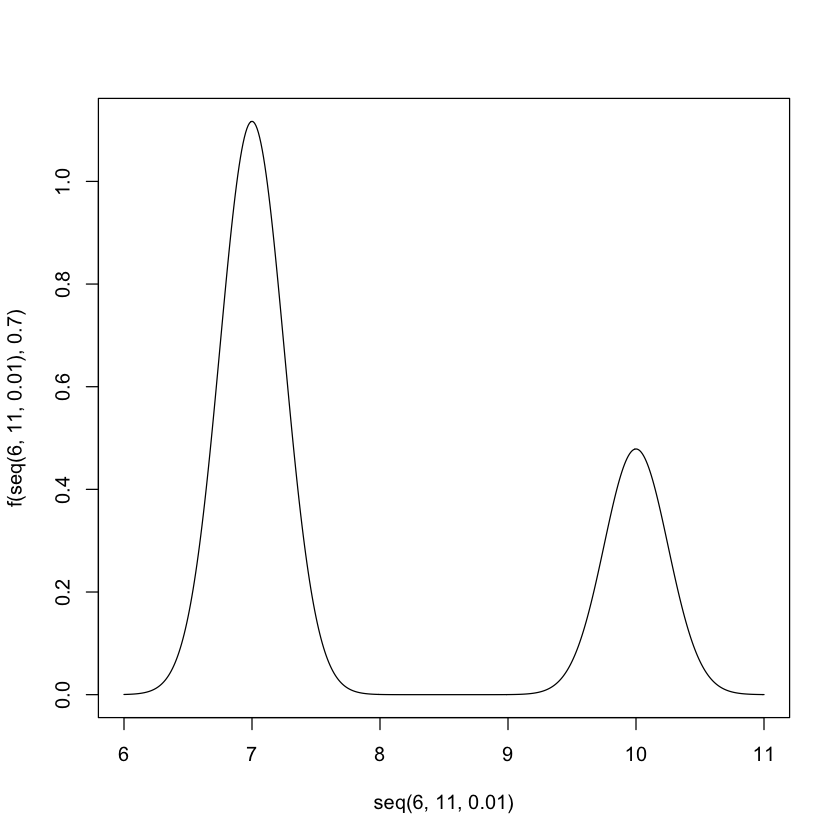

In [41]:
plot(seq(6,11,0.01),f(seq(6,11,0.01), 0.7), type= 'l')

 ## a)
a.  Write a function that samples from this distribution (so it will call $\delta$ as an argument).\\[5pt]


In [42]:
Draw <- function(n, delta) {
    #
    # Draws n random variates from the distribution f.
    #
    # Args:
    #    n: number of random variates to draw from the distribution.
    #    delta: delta parameter in distribution.
    # Returns:
    #    out: a list of n random variates drawn from f.
    
    out <- c()
    
    for (i in (1:n)) {
        
        if (runif(1) < delta) { #if a random uniform is less than delta
            out[i] <- rnorm(1,7,0.25) 
        }
    
        else {
            out[i] <- rnorm(1,10,0.25) 
        }
        }
    return(out)
}

 ## b)
b.  Let $\delta=.7$.  Sample $n=100$ observations from this distribution and present a histogram.\\[5pt]

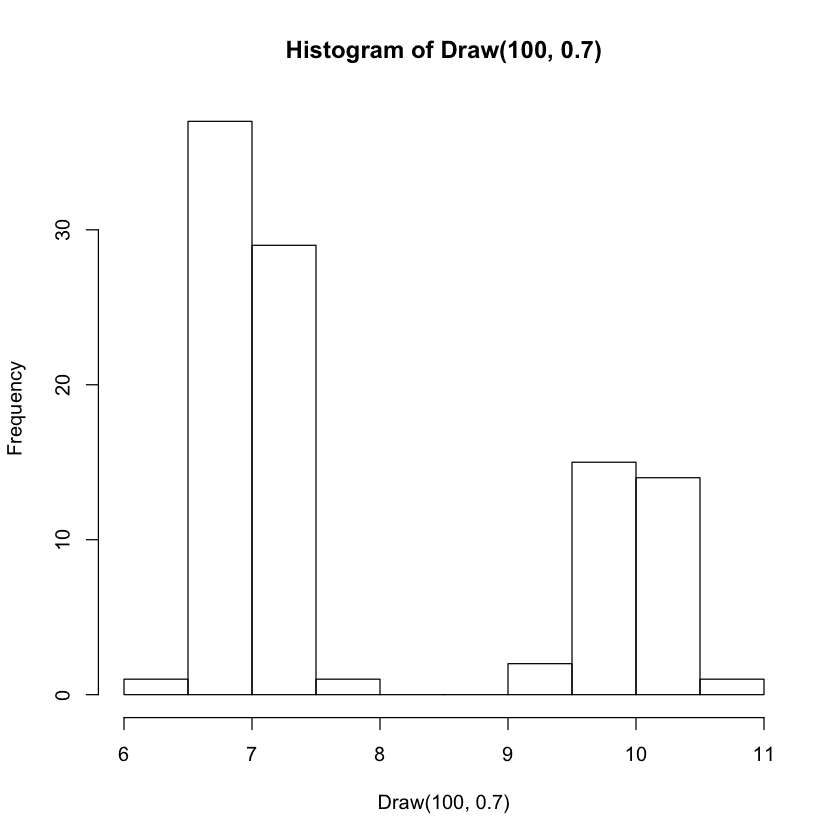

In [43]:
hist(Draw(100,0.7))

 ## c)

c. Consider a Bayesian analysis and find the posterior distribution of $\delta$ given that the prior distribution on $\delta$ is uniform (a so-called non-informative prior).  Plot a function that is proportional to the posterior distribution (the best you are going to be able to do)

Using Bayesian inference on this data set:

$f(\theta|x) \propto f(\theta) \Pi_{i=1}^{n} f(x_{i}|\theta)$

The prior is proportional to the uniform, so we can set $\theta = 1$ for the support.

In [56]:
Prior <- function(x) {
    #
    # A function for a uniform prior, which always returns 1.
    #
    # Args:
    #    x: value for which to evaluate the prior
    #    
    # Returns:
    #    y: 1.0
    
    return(1.0)
}

BayesInf <- function(obs, f, prior, delta) {
    #
    # Evaluates Bayes' formula for a function with a prior and a set of observations.
    #
    # Args:
    #    obs: set of observations
    #    f: pdf which is being evaluated
    #    prior: Bayesian prior function
    #    delta: the delta value 
    
    # Returns:
    #   
    
    terms <- c()
    
    i <- 0
    for (ob in obs) {
        i <- i + 1
        terms[i] <- f(ob, delta)
    }
    return(prior(delta)*prod(terms))
}

BayesGrid <- function(obs, f, prior, inputs) {
    #
    # Evaluates the posterior probability at a variety of deltas
    #
    # Args:
    #    obs: set of observations to use in Bayesian analysis
    #    f: the pdf 
    #    prior: the prior in bayesian analysis
    #    inputs: the values of delta for which to evaluate the posterior
    # Returns:
    #   out: the Bayesian function evaluated for many deltas
    
    out <- c()
    i <- 0 
    
    for (p in inputs) {
        i <- i + 1
        out[i] <- BayesInf(obs, f, prior, p)
    }
    return(out)   
}

In [57]:
obs <- Draw(100,0.7)

We will now plot the posterior distribution of $\delta$. We can see that there is a peak around $\delta = 0.7$. This is the $\delta$ that we used to generate the distribution, so this is a good sign.

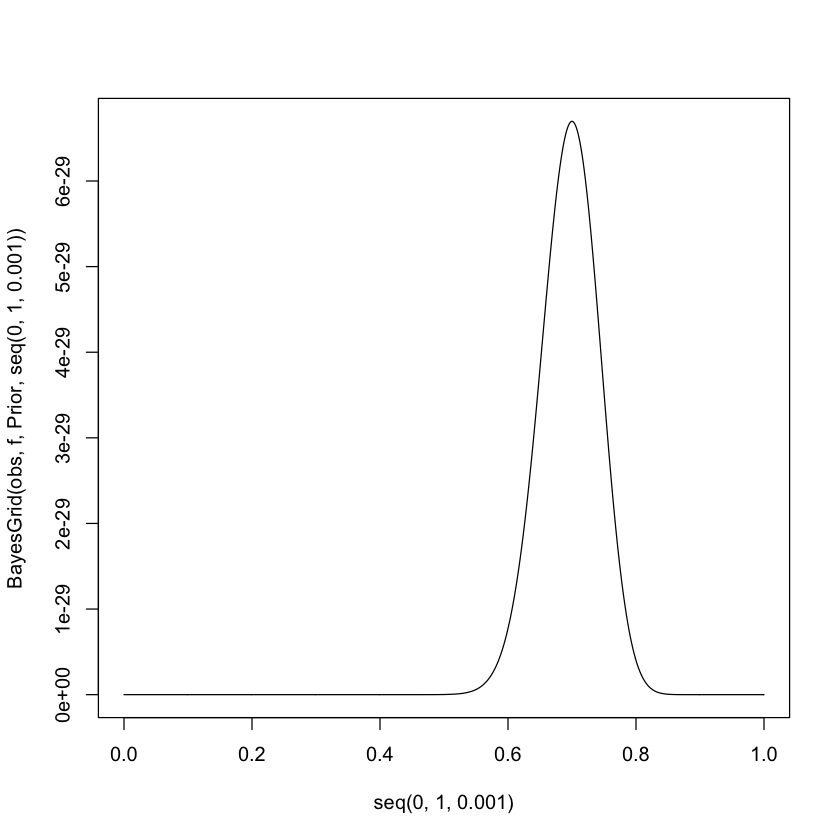

In [127]:
plot(seq(0,1,0.001), BayesGrid(obs, f, Prior, seq(0,1,0.001)), type = 'l')

 ## d)
 
d.  One estimate that is often used as a point estimate is the posterior mean.  Use an independence chain Metropolis Hastings algorithm to sample from the posterior and return an estimate using a candidate distribution that is uniform over the support (i.e. the candidate distribution is the same as the prior, which is often a good idea without other information).  Return the estimate of the posterior mean, and create plots that asses the 'mixing' of the chain (how quickly the chain explores the space). Use a starting value far from the true $\delta$, say $\delta_0=.1.$\\[5pt]

The Metropolis Hastings ratio (R) is:

$$R(u,v) = \frac{f(v)}{f(u)} \frac{g(u|v)}{g(v|u}) $$

with a uniform prior:

$$R(u,v) \Rightarrow \frac{g(u|v)}{g(v|u)} $$


In [153]:
MHStep <- function(x, eps, obs, f, prior) {
    #
    # Function which performs one iteration of the MH-algorithm
    #
    # Args:
    #    x: starting value for the metropolis-hastings algorithm
    #    eps: maximum step size to take in a MH algorithm step.
    #    obs: the input observations
    #    f: the pdf of the function, which takes a delta argument
    #    prior: a function of the prior distribution
    #
    # Returns:
    #    y: the next location in the MH algorithm path
    
    y <- x + eps*runif(1,-1,1) #the proposed step
    
    met_ratio <- min(1,(BayesInf(obs,f,prior,y)/BayesInf(obs,f,prior,x))) # calculate 
    
    if (runif(1) < met_ratio) {
        return(y)
    }
    
    else {
        return(x)  
    }
}

MH_alg <- function(x, eps, obs, f, prior, n_iters) {
    
    #
    # Function which performs n iterations of the Metropolis-hastings algorithm.
    #
    # Args:
    #    x: starting value for the metropolis-hastings algorithm
    #    eps: maximum step size to take in a MH algorithm step.
    #    obs: the input observations
    #    f: the pdf of the function, which takes a delta argument
    #    prior: a function of the prior distribution
    #
    # Returns:
    #    y: the next location in the MH algorithm path
    
    path <- c(x)
    
    for (i in (2:(n_iters + 1))) {
        path[i] <- MHStep(path[i-1], eps, obs, f, prior)
    }
    
    return(path)
}

IterMH_mean <- function(x, eps, obs, f, prior, iter_seq) {
    #
    # Function which performs n iterations of the Metropolis-hastings algorithm.
    #
    # Args:
    #    x: starting value for the metropolis-hastings algorithm
    #    eps: maximum step size to take in a MH algorithm step.
    #    obs: the input observations
    #    f: the pdf of the function, which takes a delta argument
    #    prior: a function of the prior distribution
    #    iter_seq: the sequence of numbers of iterations.
    #
    # Returns:
    #    means: the posterior mean evaluated for a range of number of MH iterations
    
    means <- c()
    
    for (i in (1:length(iter_seq))) {
        means[i] <- mean(MH_alg(x, eps, obs, f, prior, iter_seq[i]))
    }
    return(means)
}

Now, we will draw 1000 samples from the posterior distribution, starting the chain at $\delta = 0.1$

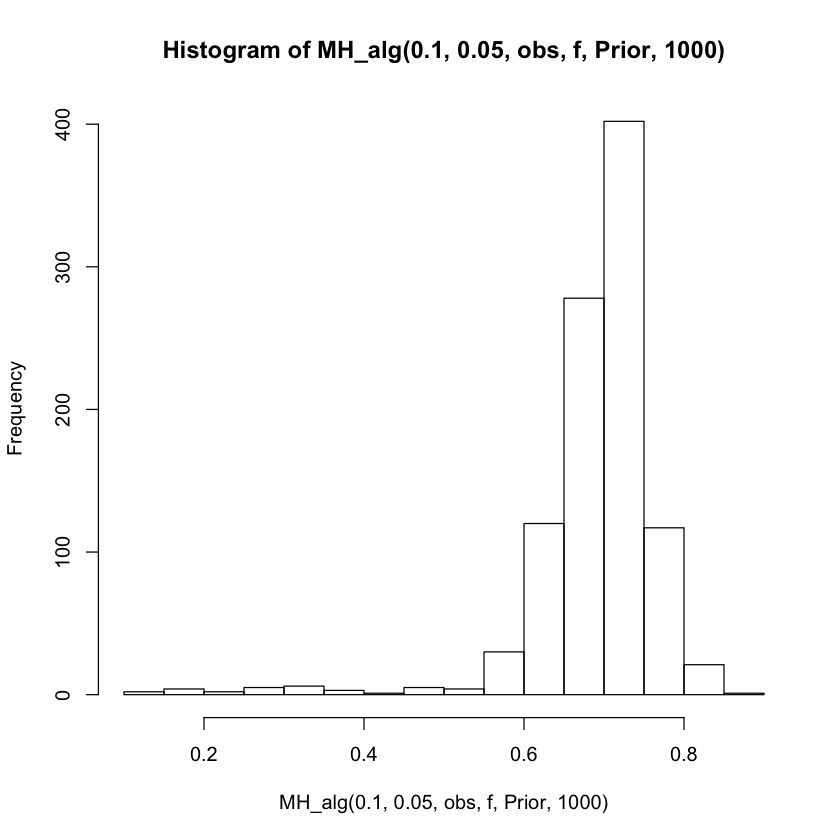

In [147]:
hist(MH_alg(0.1, 0.05, obs, f, Prior, 1000))

We will see how long it takes the chain to explore this space, by performing several MH algorithms with different number of iterations. We will start at 1 iteration, and then move up to 1000 iterations, to see how fast the posterior mean converges on its expected value of $\delta = 0.7$.

In [ ]:
iter_means <- IterMH_mean(0.1, 0.05,obs, f, Prior, seq(1,1000, by = 100))

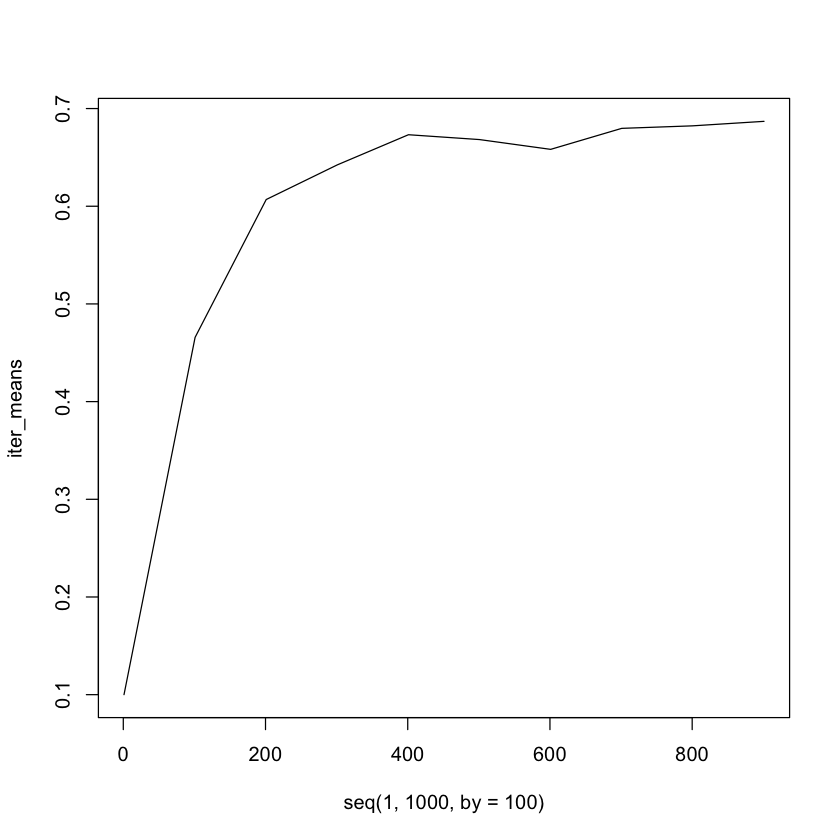

In [157]:
plot(seq(1,1000, by = 100),iter_means, type = 'l')

In [221]:
iter_means[length(iter_means)]

[1] 0.6869155

We can see that after 1000 iterations, we come to $\delta = 0.687$, only 0.013 away from 0.7

# Problem 2
 
Consider trying to estimate $\pi$ by performing a random walk inside the unit
square, where at each time point we select a point within a square centered at
your current location with side length $\epsilon$. We then look at the proportion of time
spent in the inscribed circle, which we suspect might approximate the area of
the circle, from which we can estimate the value of $\pi$. Consider two approaches:\\[5pt]

 ## a)
 
a. if you are offered to move outside the square, just ignore that value and do
it again until you are offered a `legal' point, but you move on each iteration.\\[5pt]

In [86]:
A_UnitWalk <- function(epsilon, n_iters, initial = c(0.0,0.0)) {
    #
    # Function to perform a random walk within the unit-square, rejecting possibilities outside the unit square
    #
    # Args:
    #    epsilon: the maximum step size
    #    n_iters: the number of times to perform the random walk
    #    initial: a vector of the starting x and y values
    #    
    # Returns:
    #    data_frame: a dataframe with the x and y walk positions, and their distance from the origin as a third column
    
    x <- c(initial[1])
    y <- c(initial[2])
    dist <- c(sqrt(x^(2) + y^(2)))
        
    for (i in (2:(n_iters + 1))) {
        
        newx <- (x[i-1] + runif(1,-epsilon,epsilon)[1]) 
        newy <- (y[i-1] + runif(1,-epsilon,epsilon)[1]) 
        
        while (abs(newx) > 0.5 | abs(newy) > 0.5) {
            newx <- (x[i-1] + runif(1,-epsilon,epsilon)[1]) 
            newy <- (y[i-1] + runif(1,-epsilon,epsilon)[1]) 
            }

        x[i] <- newx
        y[i] <- newy
        dist[i] <- sqrt(newx^(2) + newy^(2))
           
        }   
     
    return(data.frame(x,y,dist))
}

In [171]:
A_walk <- A_UnitWalk(0.1, 10000)

In [131]:
head(A_walk) #inspect the dataframe

,x,y,dist
1,0,0,0
2,-0.02437151,0.01841545,0.03054667
3,-0.05430019,-0.06773976,0.08681697
4,-0.06260117,-0.03003455,0.06943328
5,-0.152463879,0.008530315,0.152702327
6,-0.12891288,-0.03574339,0.13377638


We will now write a function to calculate Pi, given a dataframe like the dataframe above.

In [129]:
CalcPi <- function(square) {
    #
    # A function to calculate pi, given a dataframe of x, y coordinates and distances from the center for randomly drawn
    # points in 2D.
    #
    # Args:
    #    square: the input dataframe, from one of the UnitWalk functions defined previously
    # Returns:
    #    pi_estimate: a float of the best estimate of pi
    #


    #subset the dataframe
    in_circle <- subset(square, subset = (dist < 0.5)) #find the points in the circle
    out_circle <- subset(square, subset = (dist >= 0.5)) #find the points out of the circle

    #plot the points 
    plot(out_circle$x,out_circle$y, pch = '.',
        xlim = c(-0.5,0.5), ylim = c(-0.5,0.5))
    points(in_circle$x,in_circle$y, 
        xlim = c(-0.5,0.5), ylim = c(-0.5,0.5),pch = '.', col = 'blue')

    #estimate pi
    pi_estimate <- (length(in_circle$x)/(length(out_circle$x) + length(in_circle$x)))*4.0
    print(pi_estimate)
    
    return(pi_estimate)
    }

[1] 3.318868


[1] 3.318868

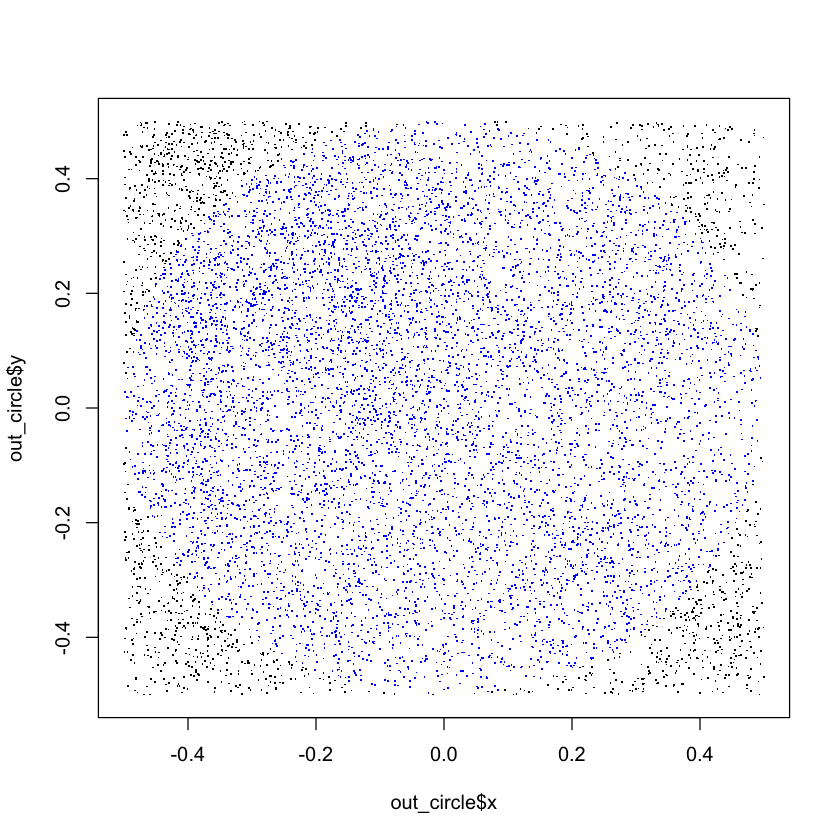

In [172]:
CalcPi(A_walk)

 ## b)
 
b. do the same as in (a), except once you are offered a legal point, only move to
that point with a probability given by the Metropolis ratio.\\[5pt]

In [340]:
Overlap <- function(c, eps, l) {  
    #
    # Function to calculate the overlapping length of a line segment centered at 0 with length l, and a line segment 
    # centered at c with length eps.
    #
    # Args:
    #    c: the center of the line segment.
    #    eps: 1/2 the length of the line segment centered around c.
    #    l: length line segment centered around 0.
    #
    # Return:
    #    overlap: length of the overlap between the two line segments    

    if (abs(c) + eps <= l) { # if the line segment is entirely within the square
        overlap <- 2*eps
    }
        
    else if (abs(c) - eps > l) { # if the line segment is entirely outside the square
        overlap <- 0
    }
        
    else { # if the line segment contains the boundary of the square
        overlap <- (l - abs(c) + eps)
    }
    return(overlap)
}

B_UnitWalk <- function(epsilon, n_iters, initial = c(0.0,0.0)) {
    #
    # Function to perform a random walk within the unit-square using a metropolis-hastings algorithm
    #
    # Args:
    #    epsilon: the maximum step size
    #    n_iters: the number of times to perform the MH-walk
    #    initial: a vector of the starting x and y values
    #    
    # Returns:
    #    data_frame: a dataframe with the x and y walk positions, and their distance from the origin as a third column
    
    
    x <- c(initial[1]) #first x from initial coordinates
    y <- c(initial[2]) #first y from initial coordinates
    dist <- c(sqrt(x^(2) + y^(2))) #calculate the first distance
        
    for (i in (2:(n_iters + 1))) {
        
        newx <- (x[i-1] + runif(1,-epsilon,epsilon)[1]) #calculate a new x
        newy <- (y[i-1] + runif(1,-epsilon,epsilon)[1]) #calculate a new y
        
        lx <- Overlap(abs(newx), epsilon, 0.5) #calculate the length of the possible values
        ly <- Overlap(abs(newy), epsilon, 0.5) #calculate the length of the possible values
        
        met_ratio <- min(1, ((lx*ly)/(4*epsilon^(2.0)))) #compute the metropolis ratio, comparing the area of the intersections.
        
        if (runif(1) < met_ratio) { #update according to the probability. Move if runif is less than met_ratio
            
            x[i] <- newx
            y[i] <- newy
            dist[i] <- sqrt(newx^(2) + newy^(2))
            
        }
        
        else { # if runif is greater than met_ratio, do not move. 
            x[i] <- x[i-1]
            y[i] <- y[i-1]
            dist[i] <- sqrt(x[i-1]^(2) + y[i-1]^(2))
        }
    }
    return(data.frame(x,y,dist))
}

[1] 2.854915


[1] 2.854915

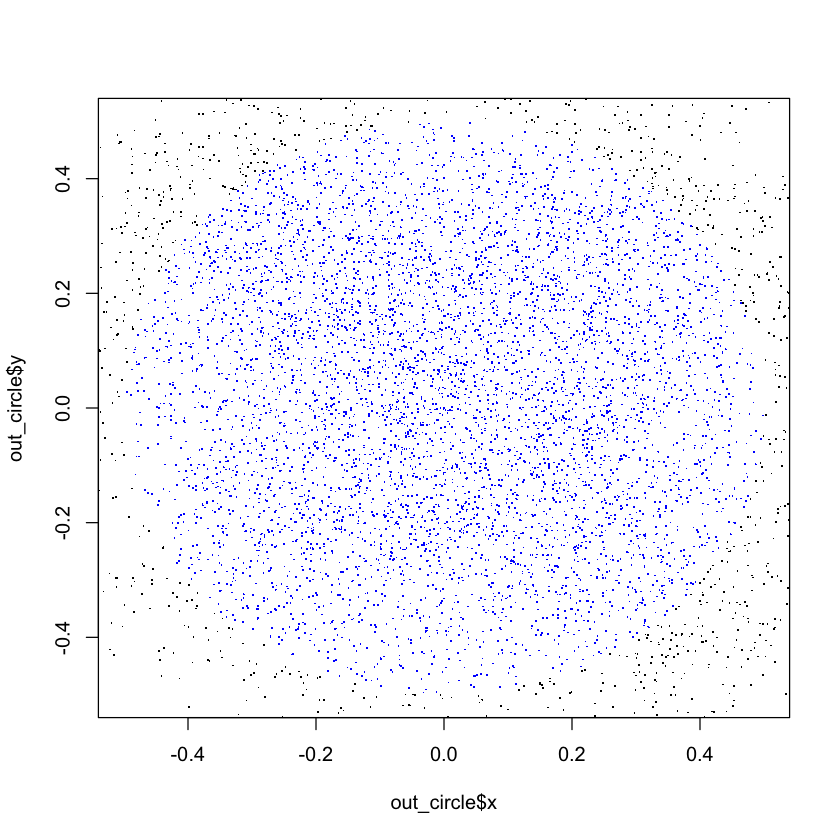

In [342]:
CalcPi(B_walk) #the algorithm is not working properly

## c)

c. How does the value of $\epsilon$ affect the estimate of $\pi$ in (a)? Give a brief explanation
of why (b) works but (a) does not.

Algorithm (a) tends to overestimate Pi because the points are drawn from the center of the circle too frequently. If a point is drawn within $\epsilon$ from the edge of the unit square, there is a chance that the choice will be rejected and that the point will have to be redrawn.  This keeps the algorithm in the center of the circle for too long, especially if $\epsilon$ is large.

Algorithm (b) should work correctly because the probability of moving from point x is proportional to the ease of moving to point x. Therefore, if the algorithm lands on a (difficult to land on) location near a corner, it stays for more iterations to compensate for this.

HOWEVER, my Algorithm (b) is not working. I think this is because the overlapping area of the two squares is not calculated correctly. I wrote the "Overlap" function to compute the overlap between two line segments. I compute the overlap independently for the x and y coordinates and multiply the x and y overlaps together to get the area of the intersecting square. If the intersecting area was calculated correctly, the metropolis ratio would ensure that random points were being drawn from the unit square.
